# Symbolic Evaluation with SymPy

In [1]:
import sympy

from joy.joy import run
from joy.library import UnaryBuiltinWrapper
from joy.utils.pretty_print import TracePrinter
from joy.utils.stack import list_to_stack

from notebook_preamble import D, J, V, define

In [2]:
sympy.init_printing()

## [SypPy Symbols](http://docs.sympy.org/latest/modules/core.html#module-sympy.core.symbol)

The SymPy package provides a powerful and elegant ["thunk"](https://en.wikipedia.org/wiki/Thunk) object that can take the place of a numeric value in calculations and "record" the operations performed on it.

We can create some of these objects and put them on the Joy stack:

In [3]:
stack = list_to_stack(sympy.symbols('c a b'))

If we evaluate the `quadratic` program

    over [[[neg] dupdip sqr 4] dipd * * - sqrt pm] dip 2 * [/] cons app2

The [SypPy Symbols](http://docs.sympy.org/latest/modules/core.html#module-sympy.core.symbol) will become the symbolic expression of the math operations.  Unfortunately, the library `sqrt` function doesn't work with the SymPy objects:

In [4]:
viewer = TracePrinter()
try:
    run('over [[[neg] dupdip sqr 4] dipd * * - sqrt pm] dip 2 * [/] cons app2', stack, D, viewer.viewer)
except Exception, e:
    print e
viewer.print_()

can't convert expression to float
                                            b a c . over [[[neg] dupdip sqr 4] dipd * * - sqrt pm] dip 2 * [/] cons app2
                                          b a c a . [[[neg] dupdip sqr 4] dipd * * - sqrt pm] dip 2 * [/] cons app2
b a c a [[[neg] dupdip sqr 4] dipd * * - sqrt pm] . dip 2 * [/] cons app2
                                            b a c . [[neg] dupdip sqr 4] dipd * * - sqrt pm a 2 * [/] cons app2
                       b a c [[neg] dupdip sqr 4] . dipd * * - sqrt pm a 2 * [/] cons app2
                                                b . [neg] dupdip sqr 4 a c * * - sqrt pm a 2 * [/] cons app2
                                          b [neg] . dupdip sqr 4 a c * * - sqrt pm a 2 * [/] cons app2
                                                b . neg b sqr 4 a c * * - sqrt pm a 2 * [/] cons app2
                                               -b . b sqr 4 a c * * - sqrt pm a 2 * [/] cons app2
                                        

We can pick out that first symbolic expression obect from the Joy stack:

In [5]:
S, E = viewer.history[-1]

In [6]:
q = S[0]
q

The Python `math.sqrt()` function causes the "can't convert expression to float" exception but `sympy.sqrt()` does not:

In [7]:
sympy.sqrt(q)

## Use `sympy.sqrt`
This is easy to fix.

In [8]:
D['sqrt'] = UnaryBuiltinWrapper(sympy.sqrt)

Now it works just fine.

In [9]:
(root1, (root2, _)) = run('over [[[neg] dupdip sqr 4] dipd * * - sqrt pm] dip 2 * [/] cons app2', stack, D)[0]

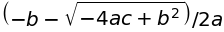

In [10]:
root1

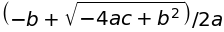

In [11]:
root2

At some point I will probably make an optional library of Joy wrappers for SymPy functions, and either load it automatically if SymPy installation is available or have a CLI switch or something.  There's a huge amount of incredibly useful stuff and I don't see why Joy shouldn't expose another interface for using it.  (As an example, the symbolic expressions can be "lambdafied" into very fast versions, i.e. a function that takes `a`, `b`, and `c` and computes the value of the root using just low-level fast code, bypassing Joy and Python.  Also, Numpy, &c.)

## Partial Evaluation

[Futamura projections](https://en.wikipedia.org/wiki/Futamura_projection)

Starting with the example from [Partial Computation of Programs](http://hdl.handle.net/2433/103401)
by [Yoshihiko Futamura](http://fi.ftmr.info/) of a function to compute `u` to the `k`th power:

In [12]:
def F(u, k):
    z = 1
    while k != 0:
        if odd(k):
            z = z * u
        k = k / 2
        u = u * u
    return z

Partial evaluation with `k = 5`:

In [13]:
def F5(u):
    z = 1 * u
    u = u * u
    u = u * u
    z = z * u
    return z

Translate `F(u, k)` to Joy

    u k 1                    # z = 1
        [pop] [Fw] while     # the while statement
        popopd               # discard u k, "return" z

What's Fw?


    u k z [pop odd] [Ft] [] ifte   # the if statement
          [2 //] dip               # k = k / 2  floordiv
          [sqr] dipd               # u = u * u

          [[sqr] dip 2 //] dip     # We can merge last two lines.

Helper function Ft (to compute z = z * u).


       u k z Ft
    ---------------
       u k u*z


    Ft == [over] dip *

Putting it together:

    Ft == [over] dip *
    Fb == [[sqr] dip 2 //] dip
    Fw == [pop odd] [Ft] [] ifte Fb
     F == 1 [pop] [Fw] while popopd

In [14]:
define('odd == 2 %')

In [15]:
define('Ft == [over] dip *')

In [16]:
define('Fb == [[sqr] dip 2 //] dip')

In [17]:
define('Fw == [pop odd] [Ft] [] ifte Fb')

In [18]:
define('F == 1 [pop] [Fw] while popopd')

Try it out:

In [19]:
J('2 5 F')

32


In order to elide the tests let's define special versions of `while` and `ifte`:

In [20]:
from joy.joy import joy
from joy.library import FunctionWrapper
from joy.parser import Symbol
from joy.utils.stack import concat


S_while = Symbol('while')


@FunctionWrapper
def while_(S, expression, dictionary):
    '''[if] [body] while'''
    (body, (if_, stack)) = S
    if joy(stack, if_, dictionary)[0][0]:
        expression = concat(body, (if_, (body, (S_while, expression))))
    return stack, expression, dictionary


@FunctionWrapper
def ifte(stack, expression, dictionary):
    '''[if] [then] [else] ifte'''
    (else_, (then, (if_, stack))) = stack
    if_res = joy(stack, if_, dictionary)[0][0]
    quote = then if if_res else else_
    expression = concat(quote, expression)
    return (stack, expression, dictionary)


D['ifte'] = ifte
D['while'] = while_

And with a SymPy symbol for the `u` argument:

In [21]:
stack = list_to_stack([5, sympy.symbols('u')])
viewer = TracePrinter()
try:
    (result, _) = run('F', stack, D, viewer.viewer)[0]
except Exception, e:
    print e
viewer.print_()

                         u 5 . F
                         u 5 . 1 [pop] [Fw] while popopd
                       u 5 1 . [pop] [Fw] while popopd
                 u 5 1 [pop] . [Fw] while popopd
            u 5 1 [pop] [Fw] . while popopd
                       u 5 1 . Fw [pop] [Fw] while popopd
                       u 5 1 . [pop odd] [Ft] [] ifte Fb [pop] [Fw] while popopd
             u 5 1 [pop odd] . [Ft] [] ifte Fb [pop] [Fw] while popopd
        u 5 1 [pop odd] [Ft] . [] ifte Fb [pop] [Fw] while popopd
     u 5 1 [pop odd] [Ft] [] . ifte Fb [pop] [Fw] while popopd
                       u 5 1 . Ft Fb [pop] [Fw] while popopd
                       u 5 1 . [over] dip * Fb [pop] [Fw] while popopd
                u 5 1 [over] . dip * Fb [pop] [Fw] while popopd
                         u 5 . over 1 * Fb [pop] [Fw] while popopd
                       u 5 u . 1 * Fb [pop] [Fw] while popopd
                     u 5 u 1 . * Fb [pop] [Fw] while popopd
                       u 5 u . Fb [pop

In [22]:
result

Let's try partial evaluation by hand and use a "stronger" thunk.

Caret underscoring indicates terms that form thunks.  When an arg is unavailable for a computation we just postpone it until the arg becomes available and in the meantime treat the pending computation as one unit.

                             u 5 . F
                             u 5 . 1 [pop] [Fw] while popopd
                           u 5 1 . [pop] [Fw] while popopd
                     u 5 1 [pop] . [Fw] while popopd
                u 5 1 [pop] [Fw] . while popopd
                           u 5 1 . Fw [pop] [Fw] while popopd
                           u 5 1 . [pop odd] [Ft] [] ifte Fb [pop] [Fw] while popopd
                 u 5 1 [pop odd] . [Ft] [] ifte Fb [pop] [Fw] while popopd
            u 5 1 [pop odd] [Ft] . [] ifte Fb [pop] [Fw] while popopd
         u 5 1 [pop odd] [Ft] [] . ifte Fb [pop] [Fw] while popopd
                           u 5 1 . Ft Fb [pop] [Fw] while popopd
                           u 5 1 . [over] dip * Fb [pop] [Fw] while popopd
                    u 5 1 [over] . dip * Fb [pop] [Fw] while popopd
                             u 5 . over 1 * Fb [pop] [Fw] while popopd
                           u 5 u . 1 * Fb [pop] [Fw] while popopd
                         u 5 u 1 . * Fb [pop] [Fw] while popopd
                           u 5 u . Fb [pop] [Fw] while popopd
                           u 5 u . [[sqr] dip 2 //] dip [pop] [Fw] while popopd
          u 5 u [[sqr] dip 2 //] . dip [pop] [Fw] while popopd
                             u 5 . [sqr] dip 2 // u [pop] [Fw] while popopd
                       u 5 [sqr] . dip 2 // u [pop] [Fw] while popopd
                               u . sqr 5 2 // u [pop] [Fw] while popopd
                               u . dup mul 5 2 // u [pop] [Fw] while popopd
                         u dup * . 5 2 // u [pop] [Fw] while popopd
                         ^^^^^^^


             u dup * 2 u [pop] [Fw] . while popopd
                        u dup * 2 u . Fw [pop] [Fw] while popopd
                        u dup * 2 u . [pop odd] [Ft] [] ifte Fb [pop] [Fw] while popopd
              u dup * 2 u [pop odd] . [Ft] [] ifte Fb [pop] [Fw] while popopd
         u dup * 2 u [pop odd] [Ft] . [] ifte Fb [pop] [Fw] while popopd
      u dup * 2 u [pop odd] [Ft] [] . ifte Fb [pop] [Fw] while popopd
                        u dup * 2 u . Fb [pop] [Fw] while popopd
                        u dup * 2 u . [[sqr] dip 2 //] dip [pop] [Fw] while popopd
       u dup * 2 u [[sqr] dip 2 //] . dip [pop] [Fw] while popopd
                          u dup * 2 . [sqr] dip 2 // u [pop] [Fw] while popopd
                    u dup * 2 [sqr] . dip 2 // u [pop] [Fw] while popopd
                            u dup * . sqr 2 2 // u [pop] [Fw] while popopd
                            u dup * . dup mul 2 2 // u [pop] [Fw] while popopd
                      u dup * dup * . 2 2 // u [pop] [Fw] while popopd
                      ^^^^^^^^^^^^^




w/ `K == u dup * dup *`

                 K 1 u [pop] [Fw] . while popopd
                            K 1 u . Fw [pop] [Fw] while popopd
                            K 1 u . [pop odd] [Ft] [] ifte Fb [pop] [Fw] while popopd
                  K 1 u [pop odd] . [Ft] [] ifte Fb [pop] [Fw] while popopd
             K 1 u [pop odd] [Ft] . [] ifte Fb [pop] [Fw] while popopd
          K 1 u [pop odd] [Ft] [] . ifte Fb [pop] [Fw] while popopd
                            K 1 u . Ft Fb [pop] [Fw] while popopd
                            K 1 u . [over] dip * Fb [pop] [Fw] while popopd
                     K 1 u [over] . dip * Fb [pop] [Fw] while popopd
                              K 1 . over u * Fb [pop] [Fw] while popopd
                            K 1 K . u * Fb [pop] [Fw] while popopd
                          K 1 K u . * Fb [pop] [Fw] while popopd
                        K 1 K u * . Fb [pop] [Fw] while popopd
                            ^^^^^

w/ `L == K u *`

                         K 1 L . Fb [pop] [Fw] while popopd
                         K 1 L . [[sqr] dip 2 //] dip [pop] [Fw] while popopd
        K 1 L [[sqr] dip 2 //] . dip [pop] [Fw] while popopd
                           K 1 . [sqr] dip 2 // L [pop] [Fw] while popopd
                     K 1 [sqr] . dip 2 // L [pop] [Fw] while popopd
                             K . sqr 1 2 // L [pop] [Fw] while popopd
                             K . dup mul 1 2 // L [pop] [Fw] while popopd
                           K K . mul 1 2 // L [pop] [Fw] while popopd
                         K K * . 1 2 // L [pop] [Fw] while popopd
                         ^^^^^
                         K K * . 1 2 // L [pop] [Fw] while popopd
                       K K * 1 . 2 // L [pop] [Fw] while popopd
                     K K * 1 2 . // L [pop] [Fw] while popopd
                       K K * 0 . L [pop] [Fw] while popopd
                     K K * 0 L . [pop] [Fw] while popopd
               K K * 0 L [pop] . [Fw] while popopd
          K K * 0 L [pop] [Fw] . while popopd
          ^^^^^
                     K K * 0 L . popopd
                             L . 

So:

    K == u dup * dup *
    L == K u *

Our result "thunk" would be:
    
    u dup * dup * u *

Mechanically, you could do:

    u      dup * dup *  u   *
    u u   [dup * dup *] dip *
    u dup [dup * dup *] dip *


    F5 == dup [dup * dup *] dip *

But we can swap the two arguments to the final `*` to get all mentions of `u` to the left:


    u u dup * dup * *


Then de-duplicate "u":


    u dup dup * dup * *


To arrive at a startlingly elegant form for F5:


    F5 == dup dup * dup * *

In [23]:
stack = list_to_stack([sympy.symbols('u')])
viewer = TracePrinter()
try:
    (result, _) = run('dup dup * dup * *', stack, D, viewer.viewer)[0]
except Exception, e:
    print e
viewer.print_()
result

          u . dup dup * dup * *
        u u . dup * dup * *
      u u u . * dup * *
     u u**2 . dup * *
u u**2 u**2 . * *
     u u**4 . *
       u**5 . 


I'm not sure how to implement these kinds of thunks.  I think you have to have support in the interpreter, or you have to modify all of the functions like `dup` to check for thunks in their inputs.

Working on the compiler, from this:

    dup dup * dup * *

We can already generate:

    ---------------------------------
    (a0, stack) = stack
    a1 = mul(a0, a0)
    a2 = mul(a1, a1)
    a3 = mul(a2, a0)
    stack = (a3, stack)
    ---------------------------------

This is pretty old stuff...  (E.g. from 1999, M. Anton Ertl [Compilation of Stack-Based Languages](http://www.complang.tuwien.ac.at/projects/rafts.html) he goes a lot further for Forth.)

## "A Transformation Based Approach to Semantics-Directed Code Generation"

by Arthur Nunes-Harwitt

https://dl.acm.org/citation.cfm?doid=2635648.2635652



In [24]:
def m(x, y): return x * y

print m(2, 3)

6


In [25]:
def m(x): return lambda y: x * y

print m(2)(3)

6


In [26]:
def m(x): return "lambda y: %(x)s * y" % locals()

print m(2)
print eval(m(2))(3)

lambda y: 2 * y
6


In Joy:

    m == [*] cons

    3 2 m i
    3 2 [*] cons i
    3 [2 *] i
    3 2 *
    6


In [27]:
def p(n, b): # original
    return 1 if n == 0 else b * p(n - 1, b)


def p(n): # curried
    return lambda b: 1 if n == 0 else b * p(n - 1, b)


def p(n): # quoted
    return "lambda b: 1 if %(n)s == 0 else b * p(%(n)s - 1, b)"  % locals()


print p(3)

lambda b: 1 if 3 == 0 else b * p(3 - 1, b)


Original

    p == [0 =] [popop 1] [-- over] [dip *] genrec

    b n p
    b n [0 =] [popop 1] [-- over [p] dip *]

    b n -- over [p] dip *
    b n-1  over [p] dip *
    b n-1 b [p] dip *
    b n-1 p b *


curried, quoted

                        n p
    ---------------------------------------------
       [[n 0 =] [pop 1] [dup n --] [*] genrec]

In [28]:
def p(n): # lambda lowered
    return (
        lambda b: 1
        if n == 0 else
        lambda b: b * p(n - 1, b)
        )


def p(n): # lambda lowered quoted
    return (
        "lambda b: 1"
        if n == 0 else
        "lambda b: b * p(%(n)s - 1, b)"  % locals()
        )

print p(3)

lambda b: b * p(3 - 1, b)



    p == [0 =] [[pop 1]] [ [-- [dup] dip p *] cons ]ifte


    3 p
    3 [-- [dup] dip p *] cons
    [3 -- [dup] dip p *]


In [29]:
def p(n): # expression lifted
    if n == 0:
        return lambda b: 1
    f = p(n - 1)
    return lambda b: b * f(b)


print p(3)(2)

8


In [30]:
def p(n): # quoted
    if n == 0:
        return "lambda b: 1"
    f = p(n - 1)
    return "lambda b: b * (%(f)s)(b)"  % locals()

print p(3)
print eval(p(3))(2)

lambda b: b * (lambda b: b * (lambda b: b * (lambda b: 1)(b))(b))(b)
8


    p == [0 =] [pop [pop 1]] [-- p [dupdip *] cons] ifte


    3 p
    3 -- p [dupdip *] cons
    2    p [dupdip *] cons
    2 -- p [dupdip *] cons [dupdip *] cons
    1    p [dupdip *] cons [dupdip *] cons
    1 -- p [dupdip *] cons [dupdip *] cons [dupdip *] cons
    0    p [dupdip *] cons [dupdip *] cons [dupdip *] cons
    0 pop [pop 1] [dupdip *] cons [dupdip *] cons [dupdip *] cons
    [pop 1] [dupdip *] cons [dupdip *] cons [dupdip *] cons
    ...
    [[[[pop 1] dupdip *] dupdip *] dupdip *]


    2 [[[[pop 1] dupdip *] dupdip *] dupdip *] i
    2  [[[pop 1] dupdip *] dupdip *] dupdip *
    2   [[pop 1] dupdip *] dupdip *  2 *
    2    [pop 1] dupdip *  2      *  2 *
    2     pop 1  2      *  2      *  2 *
              1  2      *  2      *  2 *



    p == [0 =] [pop [pop 1]] [--  p    [dupdip *] cons] ifte
    p == [0 =] [pop [pop 1]] [-- [p] i [dupdip *] cons] ifte
    p == [0 =] [pop [pop 1]] [--]   [i [dupdip *] cons] genrec

In [31]:
define('p == [0 =] [pop [pop 1]] [--] [i [dupdip *] cons] genrec')

In [32]:
J('3 p')

[[[[pop 1] dupdip *] dupdip *] dupdip *]


In [33]:
V('2 [[[[pop 1] dupdip *] dupdip *] dupdip *] i')

                                           . 2 [[[[pop 1] dupdip *] dupdip *] dupdip *] i
                                         2 . [[[[pop 1] dupdip *] dupdip *] dupdip *] i
2 [[[[pop 1] dupdip *] dupdip *] dupdip *] . i
                                         2 . [[[pop 1] dupdip *] dupdip *] dupdip *
           2 [[[pop 1] dupdip *] dupdip *] . dupdip *
                                         2 . [[pop 1] dupdip *] dupdip * 2 *
                      2 [[pop 1] dupdip *] . dupdip * 2 *
                                         2 . [pop 1] dupdip * 2 * 2 *
                                 2 [pop 1] . dupdip * 2 * 2 *
                                         2 . pop 1 2 * 2 * 2 *
                                           . 1 2 * 2 * 2 *
                                         1 . 2 * 2 * 2 *
                                       1 2 . * 2 * 2 *
                                         2 . 2 * 2 *
                                       2 2 . * 2 *
                                

In [ ]:
stack = list_to_stack([sympy.symbols('u')])
(result, s) = run('p i', stack, D)[0]
result

From this:

    p == [0 =] [pop pop 1] [-- over] [dip *] genrec

To this:

    p == [0 =] [pop [pop 1]] [--] [i [dupdip *] cons] genrec




## Try it with `F()`:

In [ ]:
def odd(n): return n % 2


def F(u, k):
    z = 1
    while k != 0:
        if odd(k):
            z = z * u
        k = k / 2
        u = u * u
    return z

F(2, 5)

In [ ]:
def F(k):
    def _F(u, k=k):
        z = 1
        while k != 0:
            if odd(k):
                z = z * u
            k = k / 2
            u = u * u
        return z
    return _F
    
F(5)(2)

In [ ]:
def F(k):
    def _F(u, k=k):
        if k == 0:
            z = 1
        else:
            z = F(k / 2)(u)
            z *= z
            if odd(k):
                z = z * u
        return z
    return _F
    
F(5)(2)

In [ ]:
def F(k):
    if k == 0:
        z = lambda u: 1
    else:
        f = F(k / 2)
        def z(u):
            uu = f(u)
            uu *= uu
            return uu * u if odd(k) else uu
    return z
    
F(5)(2)

In [ ]:
def F(k):
    if k == 0:
        z = lambda u: 1
    else:
        f = F(k / 2)
        if odd(k):
            z = lambda u: (lambda fu, u: fu * fu * u)(f(u), u)
        else:
            z = lambda u: (lambda fu, u: fu * fu)(f(u), u)
    return z
    
F(5)(2)

In [ ]:
def F(k):
    if k == 0:
        z = "lambda u: 1"
    else:
        f = F(k / 2)
        if odd(k):
            z = "lambda u: (lambda fu, u: fu * fu * u)((%(f)s)(u), u)" % locals()
        else:
            z = "lambda u: (lambda fu, u: fu * fu)((%(f)s)(u), u)" % locals()
    return z
    
source = F(5)
print source
eval(source)(2)

Hmm...

In [ ]:
for n in range(4):
    print F(n)

In [ ]:
def F(k):
    if k == 0:
        z = "lambda u: 1"
    elif k == 1:
        z = "lambda u: u"
    else:
        f = F(k / 2)
        if odd(k):
            z = "lambda u: (lambda fu, u: fu * fu * u)((%(f)s)(u), u)" % locals()
        else:
            z = "lambda u: (lambda fu, u: fu * fu)((%(f)s)(u), u)" % locals()
    return z
    
source = F(5)
print source
eval(source)(2)

In [ ]:
for n in range(4):
    print F(n)

In [ ]:
def F(k):
    if k == 0:
        z = "lambda u: 1"
    elif k == 1:
        z = "lambda u: u"
    else:
        m = k / 2
        if odd(k):
            if m == 0:
                z = "lambda u: 1"
            elif m == 1:
                z = "lambda u: u * u * u"
            else:
                z = "lambda u: (lambda fu, u: fu * fu * u)((%s)(u), u)" % F(m)
        else:
            if m == 0:
                z = "lambda u: 1"
            elif m == 1:
                z = "lambda u: u * u"
            else:
                z = "lambda u: (lambda u: u * u)((%s)(u))" % F(m)
    return z
    
source = F(5)
print source
eval(source)(2)

In [ ]:
def F(k):
    if k == 0:
        z = "lambda u: 1"
    elif k == 1:
        z = "lambda u: u"
    else:
        m = k / 2
        if m == 0:
            z = "lambda u: 1"
        
        elif odd(k):
            if m == 1:
                z = "lambda u: u * u * u"
            else:
                z = "lambda u: (lambda fu, u: fu * fu * u)((%s)(u), u)" % F(m)
        else:
            if m == 1:
                z = "lambda u: u * u"
            else:
                z = "lambda u: (lambda u: u * u)((%s)(u))" % F(m)
    return z
    
source = F(5)
print source
eval(source)(2)

In [ ]:
for n in range(7):
    source = F(n)
    print n, '%2i' % eval(source)(2), source

So that gets pretty good, eh?


But looking back at the definition in Joy, it doesn't seem easy to directly apply this technique to Joy code:

    Ft == [over] dip *
    Fb == [[sqr] dip 2 //] dip
    Fw == [pop odd] [Ft] [] ifte Fb
     F == 1 [pop] [Fw] while popopd


But a direct translation of the Python code..?


    F == [
      [[0 =] [pop 1]]
      [[1 =] []]
      [_F.0]
      ] cond

    _F.0 == dup 2 // [
      [[0 =]     [pop 1]]
      [[pop odd] _F.1]
      [_F.2]
      ] cond

    _F.1 == [1 =] [pop [dup dup * *]] [popd F [dupdip over * *] cons] ifte
    _F.2 == [1 =] [pop [dup *]]       [popd F [i dup *]         cons] ifte


Try it:

    5 F
    5 [ [[0 =] [pop 1]] [[1 =] []] [_F.0] ] cond
    5 _F.0
    5 dup 2 // [ [[0 =] [pop 1]] [[pop odd] _F.1] [_F.2] ] cond
    5 5 2 //   [ [[0 =] [pop 1]] [[pop odd] _F.1] [_F.2] ] cond

    5 2 [ [[0 =] [pop 1]] [[pop odd] _F.1] [_F.2] ] cond
    5 2 _F.1
    5 2 [1 =] [popop [dup dup * *]] [popd F [dupdip over * *] cons] ifte
    5 2                              popd F [dupdip over * *] cons
      2                                   F [dupdip over * *] cons

    2 F [dupdip over * *] cons

    2 F
    2 [ [[0 =] [pop 1]] [[1 =] []] [_F.0] ] cond
    2 _F.0
    2 dup 2 // [ [[0 =] [pop 1]] [[pop odd] _F.1] [_F.2] ] cond
    2 2 2 // [ [[0 =] [pop 1]] [[pop odd] _F.1] [_F.2] ] cond
    2 1 [ [[0 =] [pop 1]] [[pop odd] _F.1] [_F.2] ] cond
    2 1 _F.2
    2 1 [1 =] [popop [dup *]] [popd F [i dup *] cons] ifte
    2 1 popop [dup *]
    [dup *]


    2 F     [dupdip over * *] cons
    [dup *] [dupdip over * *] cons
    [[dup *] dupdip over * *]

And here it is in action:

    2 [[dup *] dupdip over * *] i
    2  [dup *] dupdip over * *
    2   dup *  2      over * *
    2   2   *  2      over * *
    4          2      over * *
    4          2      4    * *
    4          8             *
    32



So, it works, but in this case the results of the partial evaluation are more elegant.






## Try it with `hylomorphism()`:

In [ ]:
def hylomorphism(c, F, P, G):
    '''Return a hylomorphism function H.'''

    def H(a):
        if P(a):
            result = c
        else:
            b, aa = G(a)
            result = F(b, H(aa))
        return result

    return H

### First, curry

With abuse of syntax:

In [ ]:
def hylomorphism(c):
    return lambda F: lambda P: lambda G: lambda a: (
        if P(a):
            result = c
        else:
            b, aa = G(a)
            result = F(b)(H(aa))
        return result
    )


### lambda lowering


In [ ]:
def hylomorphism(c):
    def r(a):
        def rr(P):
            if P(a):
                return lambda F: lambda G: c
            return lambda F: lambda G: (
                    b, aa = G(a)
                    return F(b)(H(aa))
                )
        return rr
    return r



### expression lifting


In [ ]:
def hylomorphism(c):
    def r(a):
        def rr(P):
            def rrr(G):
                if P(a):
                    return lambda F: c
                b, aa = G(a)
                H = hylomorphism(c)(aa)(P)(G)
                return lambda F: F(b)(H(F))
            return rrr
        return rr
    return r



### quoted


In [ ]:
def hylomorphism(c):
    def r(a):
        def rr(P):
            def rrr(G):
                if P(a):
                    return "lambda F: %s" % (c,)
                b, aa = G(a)
                H = hylomorphism(c)(aa)(P)(G)
                return "lambda F: F(%(b)s)((%(H)s)(F))" % locals()
            return rrr
        return rr
    return r



In [ ]:
hylomorphism(0)(3)(lambda n: n == 0)(lambda n: (n-1, n-1))

In [ ]:
def F(a):
    def _F(b):
        print a, b
        return a + b
    return _F


In [ ]:
F(2)(3)

In [ ]:
eval(hylomorphism(0)(5)(lambda n: n == 0)(lambda n: (n-1, n-1)))(F)

In [ ]:
eval(hylomorphism([])(5)(lambda n: n == 0)(lambda n: (n-1, n-1)))(lambda a: lambda b: [a] + b)

In [ ]:
hylomorphism(0)([1, 2, 3])(lambda n: not n)(lambda n: (n[0], n[1:]))

In [ ]:
hylomorphism([])([1, 2, 3])(lambda n: not n)(lambda n: (n[1:], n[1:]))

In [ ]:
eval(hylomorphism([])([1, 2, 3])(lambda n: not n)(lambda n: (n[1:], n[1:])))(lambda a: lambda b: [a] + b)

In [ ]:
def hylomorphism(c):
    return lambda a: lambda P: (
        if P(a):
            result = lambda F: lambda G: c
        else:
            result = lambda F: lambda G: (
                b, aa = G(a)
                return F(b)(H(aa))
            )
        return result
    )


In [ ]:
def hylomorphism(c):
    return lambda a: (
        lambda F: lambda P: lambda G: c
        if P(a) else
        lambda F: lambda P: lambda G: (
            b, aa = G(a)
            return F(b)(H(aa))
        )
    )


In [ ]:
def hylomorphism(c):
    return lambda a: lambda G: (
        lambda F: lambda P: c
        if P(a) else
        b, aa = G(a)
        lambda F: lambda P: F(b)(H(aa))
    )
